# AI vs Human — EDA & Data Engineering

**Notebook purpose:** Thorough exploratory data analysis and data engineering steps for the `ai_vs_human` dataset. This notebook uses matplotlib for plotting (one plot per cell) and prepares cleaned & split datasets for downstream training.

**Expected local data path:** `data/ai_vs_human.csv`

---

In [1]:
# Install dependencies (run this cell in your environment if needed)
# You can comment these out if packages are already installed.
!pip install -q pandas scikit-learn matplotlib nltk wordcloud tqdm xgboost joblib


^C



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import joblib
from tqdm import tqdm
import seaborn as sns
tqdm.pandas()

# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')

print('libraries imported')

libraries imported


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load dataset
DATA_PATH = 'data/ai_vs_human.csv'  # change if needed
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please put the CSV there.")
df = pd.read_csv(DATA_PATH)
print('shape:', df.shape)
df.head()

shape: (1367, 17)


,text_content,content_type,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
0,Score each cause. Quality throughout beautiful...,academic_paper,288,1927,54,0.9514,5.33,5.69,0.0280,53.08,7.41,1,0.1041,105.86,0.5531,0.2034,1
1,Board its rock. Job worker break tonight coupl...,essay,253,1719,45,0.9723,5.62,5.80,0.0262,50.32,8.10,6,0.2045,100.29,0.5643,0.4854,1
2,Way debate decision produce. Dream necessary c...,academic_paper,420,2849,75,0.9071,5.60,5.79,0.0263,46.86,7.86,5,0.2308,96.88,0.4979,-0.2369,1
3,Story turn because such during open model. Tha...,creative_writing,196,1310,34,0.9592,5.76,5.69,0.0260,53.80,7.00,2,0.1912,88.79,0.6241,NaN,1
4,Place specific as simply leader fall analysis....,news_article,160,1115,28,0.9688,5.71,5.97,0.0251,44.53,8.29,0,0.1318,26.15,0.2894,NaN,1


In [3]:
# Basic info & missing values
print(f'missing value in data')
display(df.info())

#show duplicated data
print(f'Duplicated data = {df.duplicated().sum()}')

#show shape
print(f'Shape = {df.shape}')

missing value in data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_content          1367 non-null   object 
 1   content_type          1367 non-null   object 
 2   word_count            1367 non-null   int64  
 3   character_count       1367 non-null   int64  
 4   sentence_count        1367 non-null   int64  
 5   lexical_diversity     1367 non-null   float64
 6   avg_sentence_length   1367 non-null   float64
 7   avg_word_length       1367 non-null   float64
 8   punctuation_ratio     1367 non-null   float64
 9   flesch_reading_ease   1288 non-null   float64
 10  gunning_fog_index     1332 non-null   float64
 11  grammar_errors        1367 non-null   int64  
 12  passive_voice_ratio   1336 non-null   float64
 13  predictability_score  1367 non-null   float64
 14  burstiness            1367 non-null   float64
 15 

None

Duplicated data = 0
Shape = (1367, 17)


In [4]:
#Statistical Description
df.describe()

,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
count,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1288.000000,1332.000000,1367.000000,1336.000000,1367.000000,1367.000000,1313.000000,1367.000000
mean,140.190929,940.329188,25.610095,0.967646,5.486423,5.717783,0.027440,52.183377,7.556877,1.537674,0.150198,62.779049,0.427041,-0.007997,0.499634
std,97.410218,654.335255,17.867480,0.026254,0.447202,0.279636,0.002801,10.466570,1.866676,1.912012,0.056738,28.223550,0.199249,0.588354,0.500183
min,3.000000,14.000000,1.000000,0.875000,3.000000,4.000000,0.019400,-50.010000,1.200000,0.000000,0.050000,20.030000,0.101100,-0.999300,0.000000
25%,61.500000,410.500000,11.000000,0.951550,5.270000,5.590000,0.026100,47.712500,6.620000,0.000000,0.099675,39.015000,0.250000,-0.525800,0.000000
50%,131.000000,882.000000,24.000000,0.969200,5.480000,5.710000,0.027200,52.190000,7.515000,1.000000,0.151350,56.820000,0.408500,-0.006200,0.000000
75%,193.000000,1294.500000,35.000000,0.989100,5.700000,5.830000,0.028400,57.322500,8.390000,3.000000,0.200150,86.645000,0.594300,0.502800,1.000000
max,443.000000,2966.000000,83.000000,1.000000,8.000000,8.330000,0.071400,98.870000,27.870000,10.000000,0.250000,119.930000,0.799500,0.995900,1.000000


## Phase 2: Exploratory analysis EDA - Statistical description of the data - `label` distribution (AI vs Human) - Compare properties by content type - Verifying relationships between variables (Correlation) 

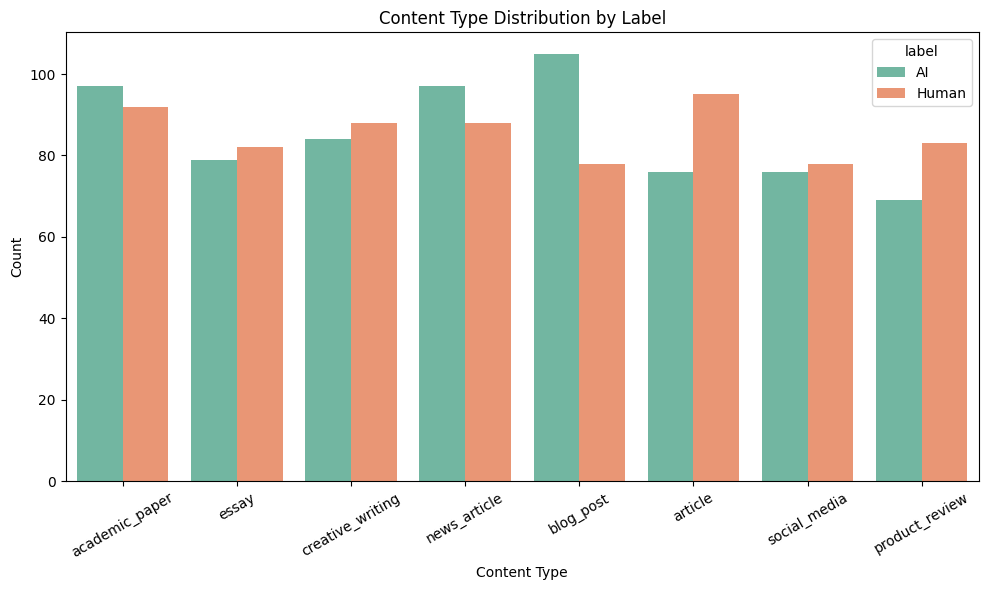

In [5]:
if df['label'].dtype != 'O':
    df['label'] = df['label'].map({0: 'Human', 1: 'AI'})

# Plot barplot of content_type with hue by label
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='content_type', hue='label', palette='Set2')
plt.title("Content Type Distribution by Label")
plt.xlabel("Content Type")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Human    684
AI       683
Name: label, dtype: int64


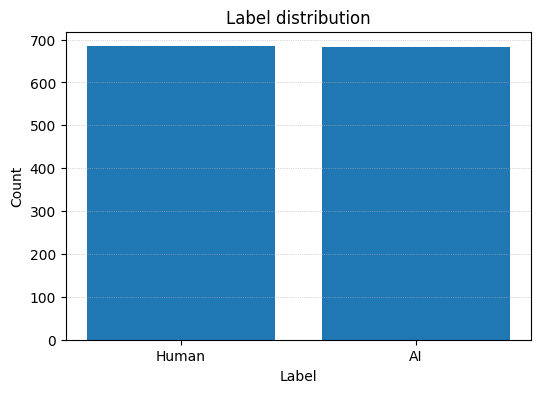

In [6]:
# Target distribution
label_col = 'label'  # adjust if different
if label_col not in df.columns:
    raise ValueError(f"Label column '{label_col}' not found in dataset columns: {df.columns.tolist()}")
counts = df[label_col].value_counts()
print(counts)

# Plot
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title('Label distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.show()

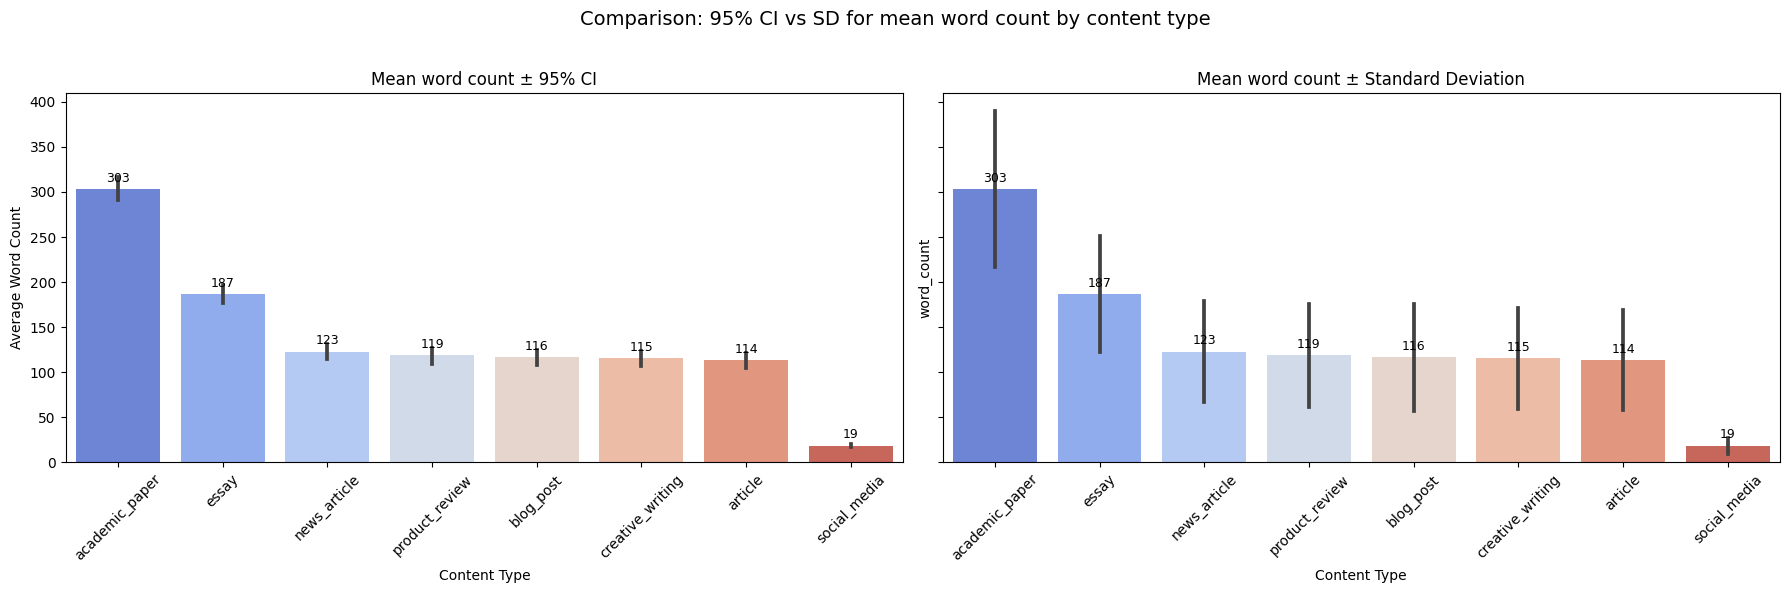

In [14]:
# ---- keep bar order consistent across both plots ----
order = df.groupby('content_type')['word_count'].mean().sort_values(ascending=False).index

# ---- create side-by-side plots ----
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Left: mean with 95% confidence interval (CI)
sns.barplot(
    data=df, x='content_type', y='word_count',
    order=order,
    errorbar=('ci', 95),      # 95% confidence interval around the mean
    estimator=np.mean,
    palette='coolwarm',
    ax=axes[0]
)
axes[0].set_title('Mean word count ± 95% CI')
axes[0].set_xlabel('Content Type')
axes[0].set_ylabel('Average Word Count')
axes[0].tick_params(axis='x', rotation=45)

# Right: mean with standard deviation (SD)
sns.barplot(
    data=df, x='content_type', y='word_count',
    order=order,
    errorbar='sd',            # standard deviation around the mean
    estimator=np.mean,
    palette='coolwarm',
    ax=axes[1]
)
axes[1].set_title('Mean word count ± Standard Deviation')
axes[1].set_xlabel('Content Type')
axes[1].tick_params(axis='x', rotation=45)

# Annotate mean values on top of each bar (for readability)
for ax in axes:
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.0f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=9, xytext=(0, 3), textcoords='offset points')

plt.suptitle('Comparison: 95% CI vs SD for mean word count by content type', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Left plot — 95% CI (black vertical line):

The CI shows uncertainty in the estimate of the mean.

* **Example reading**: if the academic_paper bar is 305 and the CI extends from 290 → 320, you can say “Given the sample, we are ~95% confident that the true mean word count for academic papers in the population lies between 290 and 320.”

* **Width depends on**: sample size (n) and variability. Larger n → narrower CI (more certainty about the mean). Large variance → wider CI.

### Right plot — Standard Deviation (SD):

* The SD shows how individual samples vary around the mean. It’s about spread of the data, not precision of the mean.

* If SD is large, that content type has high variability in individual word counts (some very short, some very long).

* SD bars are typically much wider than CI bars when sample sizes are decent, because SD measures data scatter while CI measures uncertainty of the mean (SD / sqrt(n)).

In [16]:
# Text length features
text_col = 'text_content'  # adjust if different
if text_col not in df.columns:
    raise ValueError(f"Text column '{text_col}' not found in dataset columns: {df.columns.tolist()}")
df['text_len_chars'] = df[text_col].astype(str).progress_apply(len)
df['text_len_words'] = df[text_col].astype(str).progress_apply(lambda x: len(x.split()))
df[['text_len_chars','text_len_words']].describe()

100%|██████████| 1367/1367 [00:00<00:00, 113807.34it/s]


,text_len_chars,text_len_words
count,1367.000000,1367.000000
mean,940.329188,140.190929
std,654.335255,97.410218
min,14.000000,3.000000
25%,410.500000,61.500000
50%,882.000000,131.000000
75%,1294.500000,193.000000
max,2966.000000,443.000000


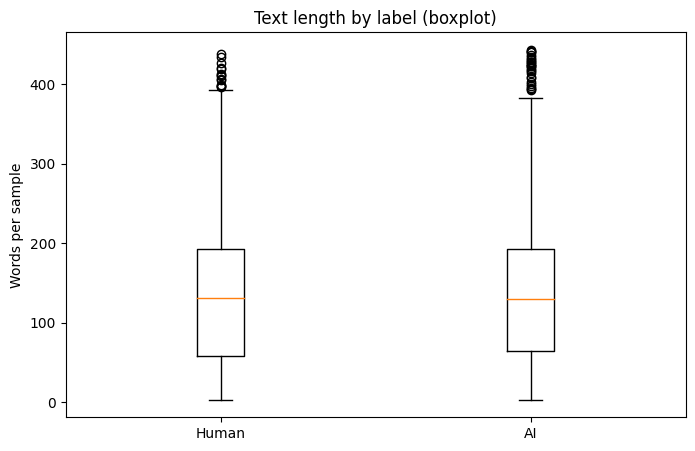

In [18]:
# Boxplot: words per sample by label
groups = [df[df[label_col]==lab]['text_len_words'].dropna().values for lab in counts.index]
plt.figure(figsize=(8,5))
plt.boxplot(groups, labels=counts.index.astype(str))
plt.ylabel('Words per sample')
plt.title('Text length by label (boxplot)')
plt.show()

* Box (rectangle):

    * Lower edge = 25th percentile (Q1).

    * Upper edge = 75th percentile (Q3).

    * Middle line = median (Q2).

* Whiskers (lines above/below box):

    * Extend to ~1.5 × IQR (interquartile range).

    * Show the “typical” spread of most data points.

* Circles (dots above whiskers):

    * These are outliers — unusually long texts compared to the rest.

* Both Human and AI texts have very similar median word counts (around ~120–130 words).

* Spread (IQR): both distributions have wide variability — many texts are short (~50 words), but some extend above 200+.

* Whiskers: extend up to ~380–400 words for both classes.

* Outliers: several texts (both AI and Human) go beyond 400 words, indicating there are a few very long samples.

**Conclusion**: Word count alone won’t be enough to separate AI vs Human, because their distributions overlap heavily. This suggests we’ll need richer textual features (TF-IDF, n-grams, embeddings, etc.) for classification.

In [20]:
# Simple text cleaning function
STOPWORDS = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+',' ', text)            # remove urls
    text = re.sub(r'[^a-z0-9\s]', ' ', text)      # keep alphanum + spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# sample
df['clean_text'] = df[text_col].astype(str).progress_apply(clean_text)
df[['text_content','clean_text']].head()

  0%|          | 0/1367 [00:00<?, ?it/s]

100%|██████████| 1367/1367 [00:00<00:00, 12366.09it/s]


,text_content,clean_text
0,Score each cause. Quality throughout beautiful...,score each cause quality throughout beautiful ...
1,Board its rock. Job worker break tonight coupl...,board its rock job worker break tonight couple...
2,Way debate decision produce. Dream necessary c...,way debate decision produce dream necessary ch...
3,Story turn because such during open model. Tha...,story turn because such during open model that...
4,Place specific as simply leader fall analysis....,place specific as simply leader fall analysis ...


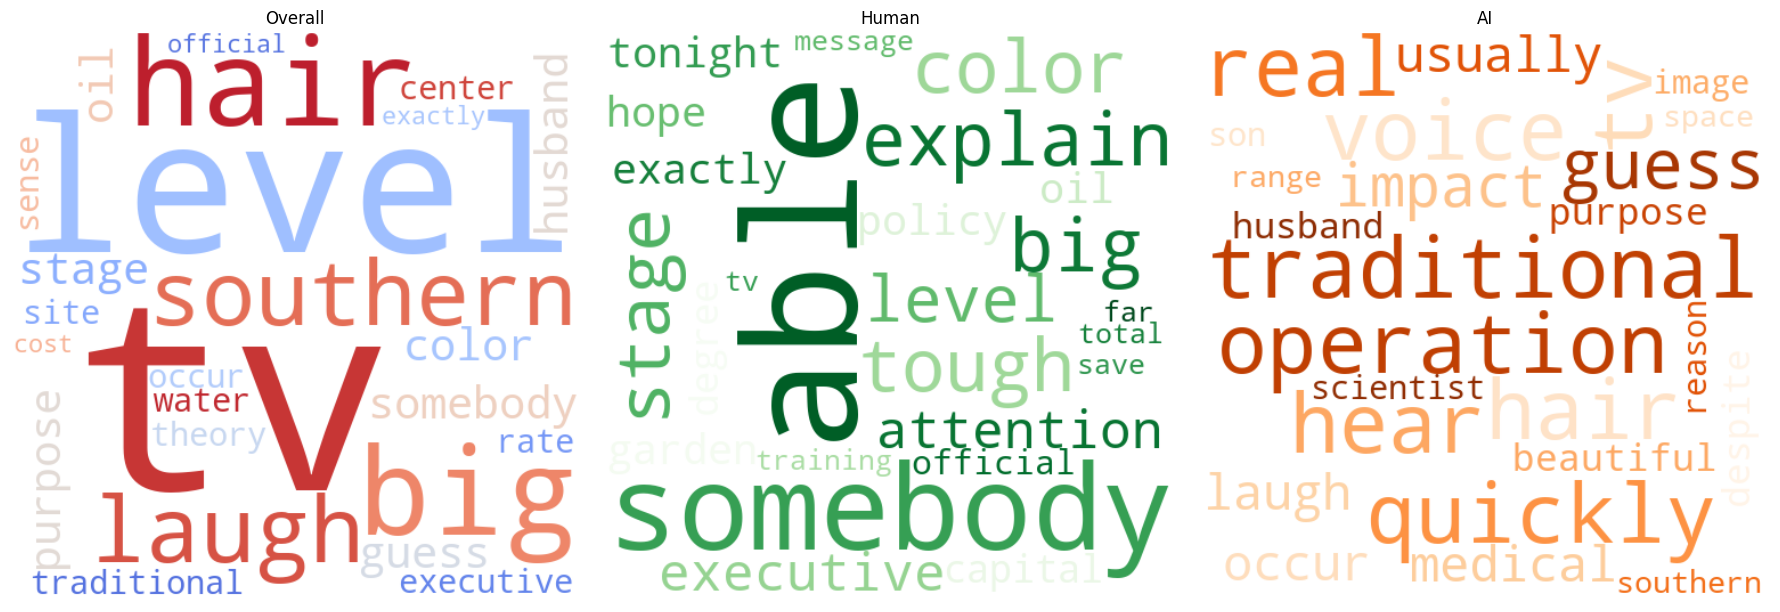

In [24]:
# Top words overall and per class (after cleaning)
def get_top_n_words(text_series, n=25, stopwords_set=STOPWORDS):
    counter = Counter()
    for doc in text_series.dropna():
        tokens = [w for w in word_tokenize(doc) if w.isalpha() and w not in stopwords_set]
        counter.update(tokens)
    return counter.most_common(n)

top_overall = get_top_n_words(df['clean_text'], n=25)
# print('Top overall words:', top_overall[:10])

# top per class
top_per_class = {}
for lab in counts.index:
    top_per_class[lab] = get_top_n_words(df[df[label_col]==lab]['clean_text'], n=25)
    # print(f"\nTop words for {lab}:", top_per_class[lab][:10])

overall_dict = dict(top_overall)
human_dict = dict(top_per_class['Human'])
ai_dict = dict(top_per_class['AI'])

# Generate word clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Overall word cloud
wc_overall = WordCloud(width=500, height=500, background_color="white", colormap="coolwarm").generate_from_frequencies(overall_dict)
axes[0].imshow(wc_overall, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Overall")

# Human word cloud
wc_human = WordCloud(width=500, height=500, background_color="white", colormap="Greens").generate_from_frequencies(human_dict)
axes[1].imshow(wc_human, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Human")

# AI word cloud
wc_ai = WordCloud(width=500, height=500, background_color="white", colormap="Oranges").generate_from_frequencies(ai_dict)
axes[2].imshow(wc_ai, interpolation="bilinear")
axes[2].axis("off")
axes[2].set_title("AI")

plt.tight_layout()
plt.show()


* Gives an intuitive feel for the vocabulary distribution.
* Larger words = more frequent.
* Helps quickly see if AI uses more repetitive technical terms vs humans using varied natural words.
* Color maps (coolwarm, Greens, Oranges) make each class distinct.

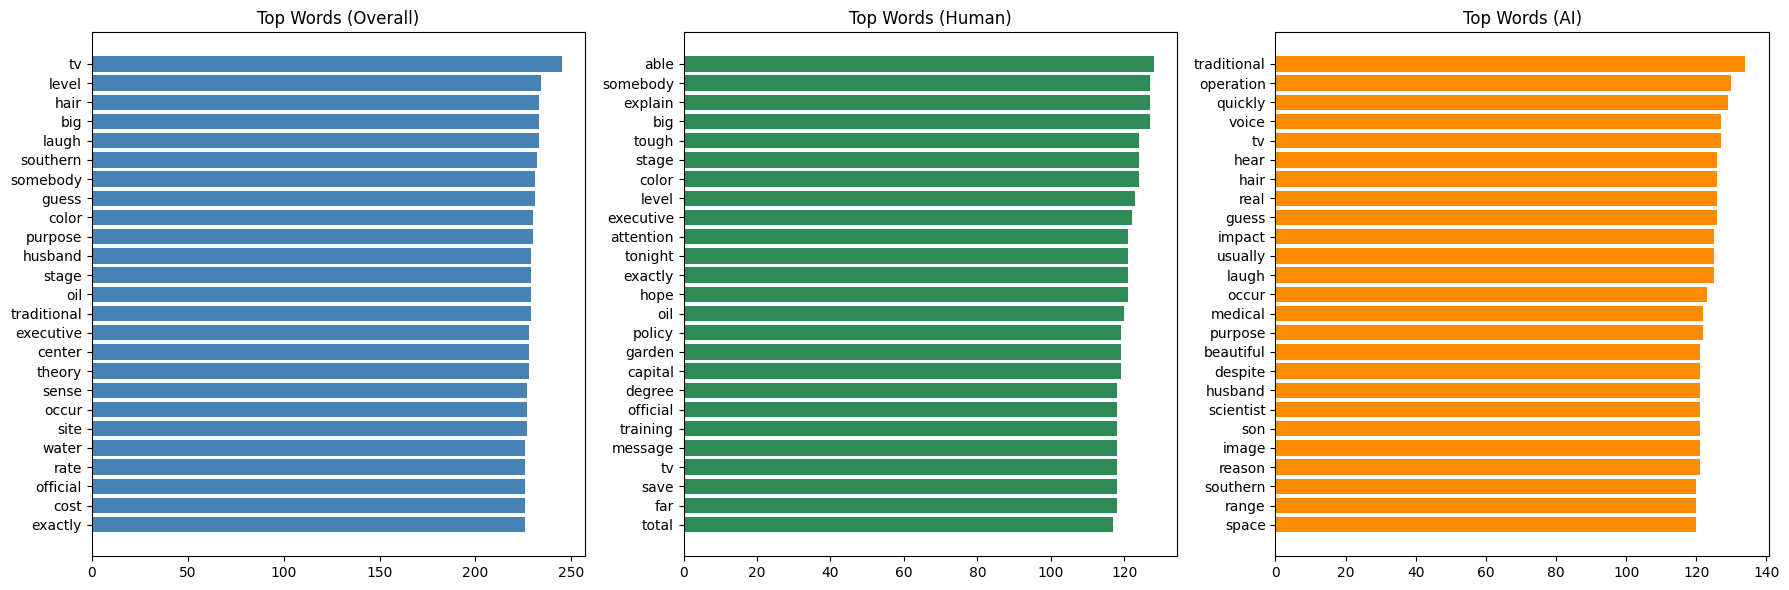

In [25]:
# Plot 3 horizontal bar charts side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Overall
axes[0].barh(list(overall_dict.keys()), list(overall_dict.values()), color='steelblue')
axes[0].set_title("Top Words (Overall)")
axes[0].invert_yaxis()

# Human
axes[1].barh(list(human_dict.keys()), list(human_dict.values()), color='seagreen')
axes[1].set_title("Top Words (Human)")
axes[1].invert_yaxis()

# AI
axes[2].barh(list(ai_dict.keys()), list(ai_dict.values()), color='darkorange')
axes[2].set_title("Top Words (AI)")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

* Shows the exact frequency values of the top words.
* You can directly compare whether “data” appears 50 times in AI but only 10 times in Human.
* It’s quantitative and helps in spotting the strongest differentiators.

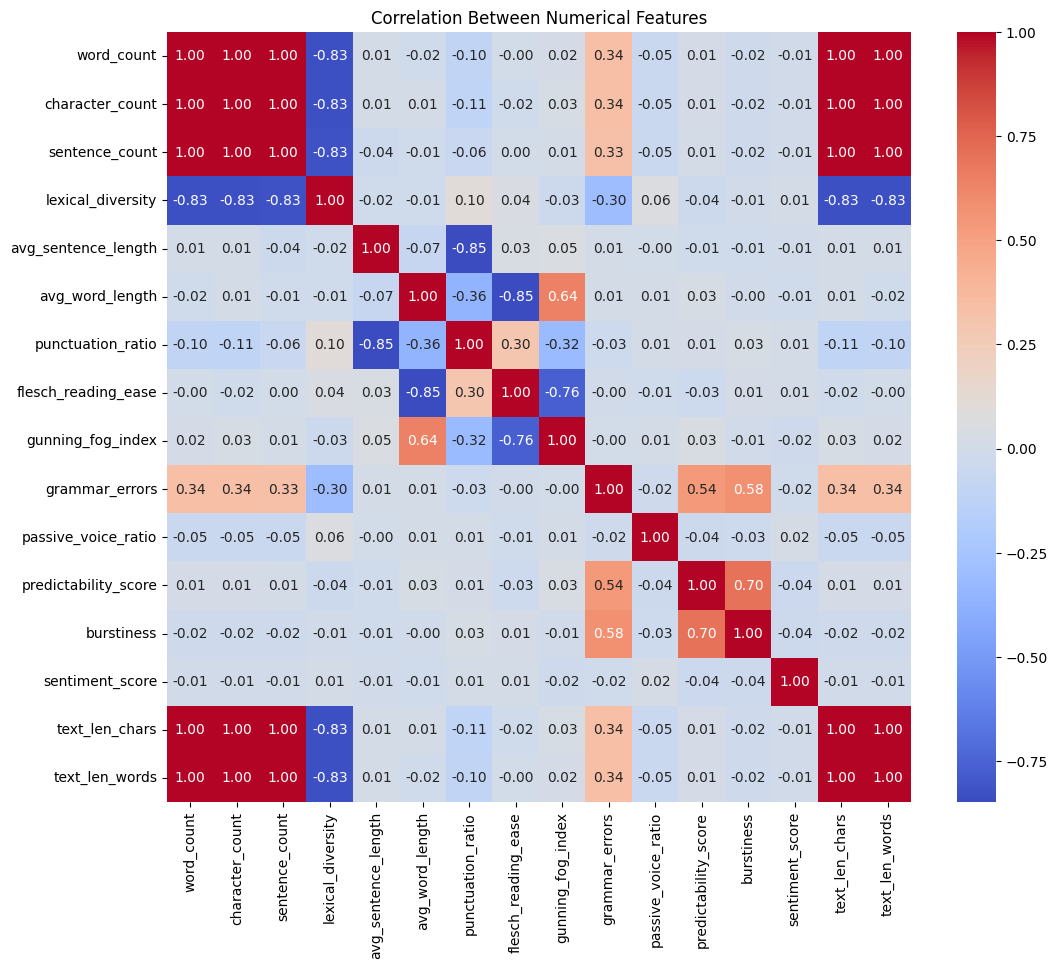

In [30]:
#Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include='number').corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numerical Features")
plt.show()

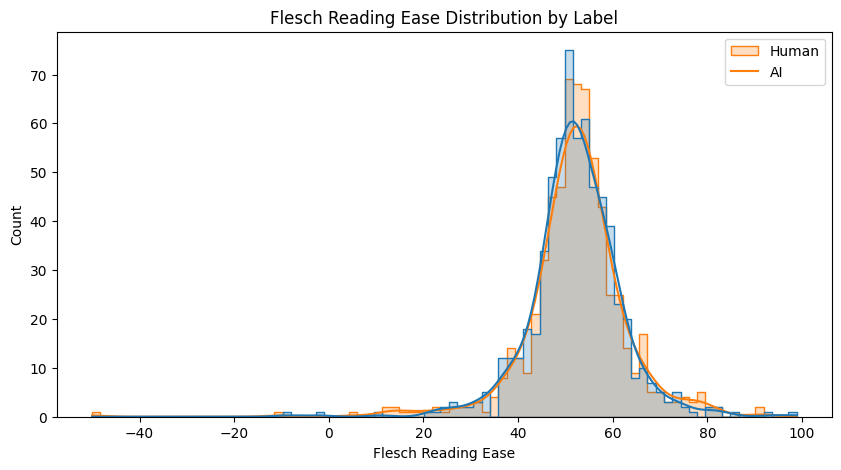

In [33]:
#We will see whether artificial intelligence writes texts that are easier or more difficult to read
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='flesch_reading_ease', hue='label', kde=True, element='step')
plt.title("Flesch Reading Ease Distribution by Label")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Count")
plt.legend(labels=["Human", "AI"])
plt.show()


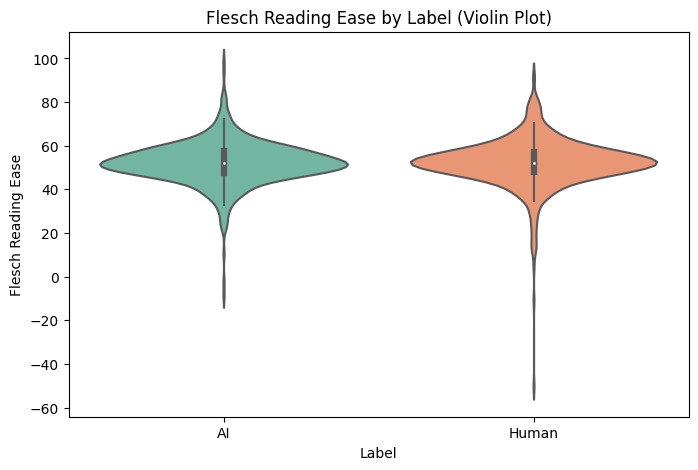

In [34]:
plt.figure(figsize=(8,5))
sns.violinplot(
    data=df, 
    x='label', 
    y='flesch_reading_ease', 
    palette='Set2', 
    inner='box'   # shows a mini boxplot inside the violin
)
plt.title("Flesch Reading Ease by Label (Violin Plot)")
plt.xlabel("Label")
plt.ylabel("Flesch Reading Ease")
plt.show()

## Flesch Reading Ease score

* A higher score = easier to read (simple words, short sentences).
* A lower score = harder to read (complex words, long sentences).

* Rough scale:

  * 90–100 → very easy (like kids’ books)
  * 60–70 → plain English (magazines, blogs)
  * 30–50 → difficult (academic papers)
  * 0–30 → very hard (legal, scientific texts)

* X-axis → Label
    * The two categories: Human vs AI.

* Y-axis → Flesch Reading Ease score
    * Higher = easier to read, Lower = harder to read (same interpretation as before).

* Violin shape → Distribution of data
    * Think of it as a rotated density plot (KDE) mirrored on both sides.
    * The wider the violin at a certain y-value → the more texts fall into that readability range.

* Inner box (optional, because of inner='box')
    * Shows a mini boxplot inside each violin.
    * Includes:
      * Median line (middle of the distribution).
      * IQR box (25th–75th percentile) = middle 50% of the data.
      * Whiskers may extend to show the broader range.

* Median comparison

    * Where the middle readability score sits for AI vs Human.
    * If they’re similar → distributions overlap a lot.

* Spread (IQR)

    * Narrower IQR (box) → more consistent readability.
    * Wider IQR → more variation.

* Distribution shape

    * Human: If violin is wider at both high and low extremes → Humans produce both very easy and very hard texts.
    * AI: If violin is centered and narrow → AI sticks to a safe readability range.

* Outliers

    * Long thin tails mean some extreme values exist (e.g., unusually complex or unusually simple samples).

In [37]:
# TF-IDF quick analysis
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['clean_text'].astype(str))
feature_names = tfidf.get_feature_names_out()
# compute mean tfidf per feature
mean_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_idx = np.argsort(mean_tfidf)[-25:][::-1]
top_features = [(feature_names[i], mean_tfidf[i]) for i in top_idx]
print('Top TF-IDF features (overall):', top_features[:10])

Top TF-IDF features (overall): [('tv', 0.012469918544908299), ('oil', 0.012357770251917824), ('laugh', 0.012174555311189324), ('southern', 0.012023337138003916), ('site', 0.011928532453029403), ('purpose', 0.011865510697345491), ('line', 0.011851056506015579), ('yeah', 0.011834320992442781), ('usually', 0.011824258039050975), ('color', 0.011761365469255141)]


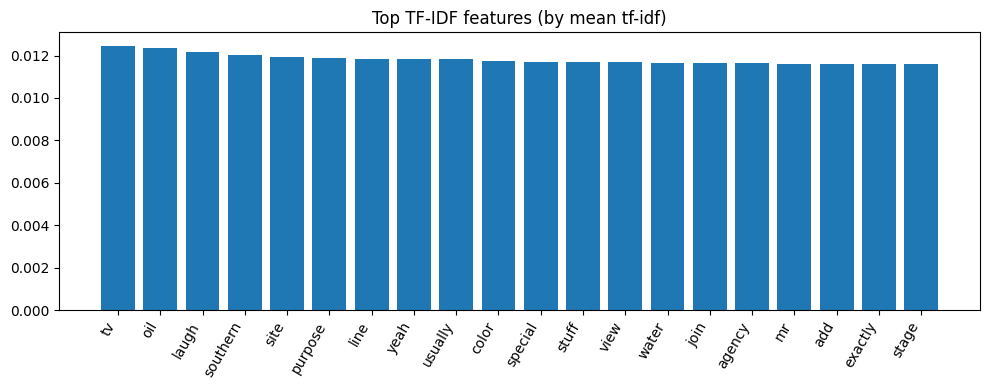

In [38]:
# Bar plot: top 20 TF-IDF features
feat_names, feat_vals = zip(*top_features[:20])
plt.figure(figsize=(10,4))
plt.bar(feat_names, feat_vals)
plt.xticks(rotation=60, ha='right')
plt.title('Top TF-IDF features (by mean tf-idf)')
plt.tight_layout()
plt.show()

In [40]:
# Mean text length by label
grouped = df.groupby(label_col)['text_len_words'].agg(['mean','median','count']).reset_index()
display(grouped)

,label,mean,median,count
0,AI,142.849195,130.0,683
1,Human,137.536550,131.0,684


In [41]:
# Save cleaned dataset and train/test split
CLEAN_PATH = 'data/ai_vs_human_cleaned.csv'
df.to_csv(CLEAN_PATH, index=False)
print('Saved cleaned data to', CLEAN_PATH)

# Train-test split stratified by label
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[label_col])
train_path = 'data/train.csv'
test_path = 'data/test.csv'
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
print('Saved train/test splits to', train_path, test_path)

Saved cleaned data to data/ai_vs_human_cleaned.csv
Saved train/test splits to data/train.csv data/test.csv


In [ ]:
# Save TF-IDF vectorizer for downstream training/inference
ARTIFACT_DIR = 'artifacts'
os.makedirs(ARTIFACT_DIR, exist_ok=True)
vec_path = os.path.join(ARTIFACT_DIR, 'tfidf_vectorizer.joblib')
joblib.dump(tfidf, vec_path)
print('Saved TF-IDF vectorizer to', vec_path)

Saved TF-IDF vectorizer to artifacts\tfidf_vectorizer.joblib


---

## Next steps (suggested)

1. Train an XGBoost classifier using the TF-IDF features saved above (`artifacts/tfidf_vectorizer.joblib`).
2. Track experiments with MLflow or a simple CSV logger.
3. Implement a `train.py` script and `inference.py` that loads the saved TF-IDF and XGBoost model, then expose via FastAPI.
4. Dockerize and deploy the FastAPI app to Heroku (or any cloud provider).

---

*Notebook generated automatically. If you want I can also generate `train.py`, `app.py`, `Dockerfile` and other scaffolding files next.*